In [1]:
from PIL import Image
import numpy as np
import utils as ut

In [2]:
import sys
import os
from PIL import Image

notebook_dir = os.path.dirname(os.path.abspath("__file__"))

test_images_path = os.path.abspath(os.path.join(notebook_dir, '../../../test_images'))



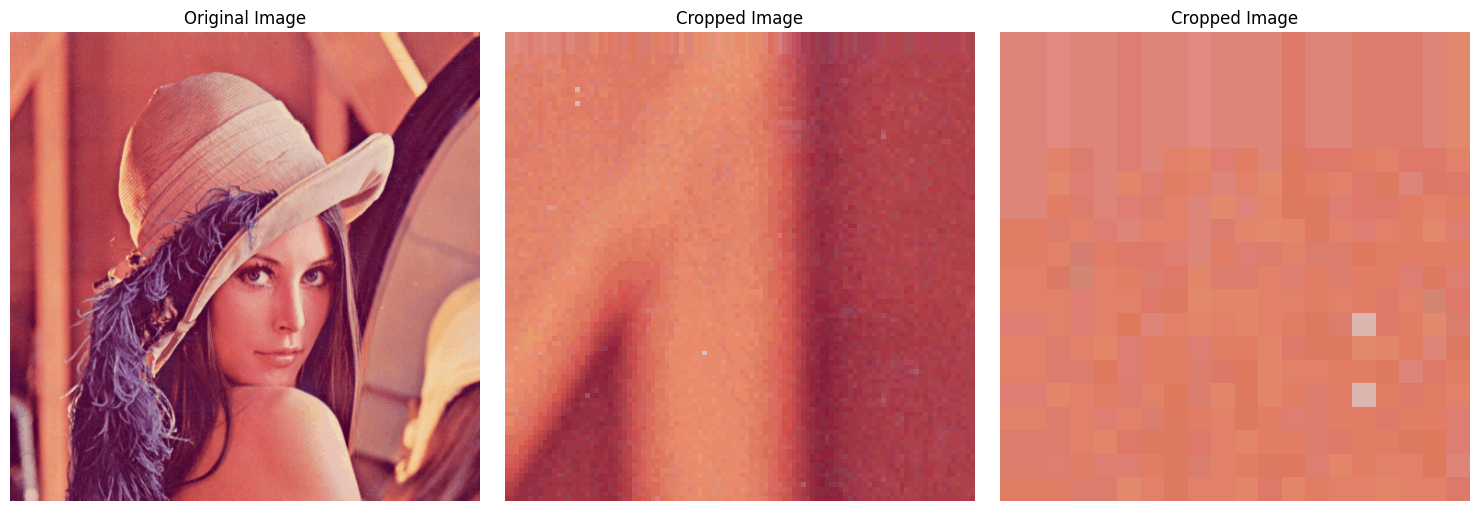

In [3]:
image_path = os.path.join(test_images_path, 'lenna.bmp')
image = Image.open(image_path)
ut.image_plotter([image, image.crop((0, 0, 100, 100)), image.crop((0,0,20,20))], ['Original Image', 'Cropped Image', 'Cropped Image'])



In [4]:
def mosaic_filter(image):

    red_bayer_pattern = np.array([
        [1, 0],
        [0, 0]
    ])

    green_bayer_pattern = np.array([
        [0, 1],
        [1, 0]
    ])

    blue_bayer_pattern = np.array([
        [0, 0],
        [0, 1]
    ])


    red_channel = np.array(image)[:, :, 0]
    green_channel = np.array(image)[:, :, 1]
    blue_channel = np.array(image)[:, :, 2]


    def apply_bayer_pattern(channel, pattern):
        row_repeat = False
        col_repeat = False

    
        if channel.shape[0] %2 != 0:
            #repeat the last row
            row_repeat = True
            channel = np.vstack((channel, channel[-1]))
        if channel.shape[1] %2 != 0:
            #repeat the last column
            col_repeat = True
            channel = np.hstack((channel, channel[:, -1].reshape(-1, 1)))
    
        for i in range(0, channel.shape[0], 2):
            for j in range(0, channel.shape[1], 2):
                channel[i:i+2, j:j+2] = channel[i:i+2, j:j+2] * pattern


        if row_repeat:
            channel = channel[:-1]
        if col_repeat:
            channel = channel[:, :-1]
        return channel
        
    red_channel = apply_bayer_pattern(red_channel, red_bayer_pattern)
    green_channel = apply_bayer_pattern(green_channel, green_bayer_pattern)
    blue_channel = apply_bayer_pattern(blue_channel, blue_bayer_pattern)


    image = np.stack((red_channel, green_channel, blue_channel), axis=-1)

    image = Image.fromarray(image.astype(np.uint8))
    return image



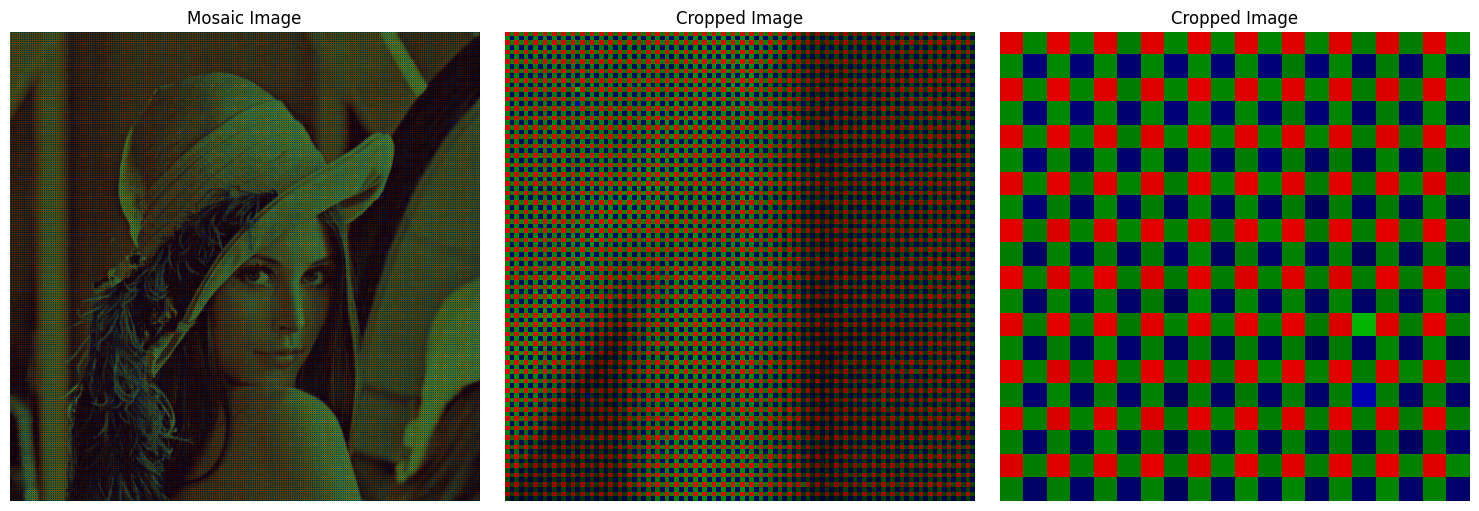

In [5]:
mosaic_image = mosaic_filter(image)
ut.image_plotter([mosaic_image, mosaic_image.crop((0, 0, 100, 100)), mosaic_image.crop((0,0,20,20))], ['Mosaic Image', 'Cropped Image', 'Cropped Image'])